<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/computationalImaging/blob/master/rays/codedApertureTomography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Coded Aperture Tomography
###David Brady
### University of Arizona

Section 4.4 of **Computational Imaging**

### Python modules

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy import signal
from scipy import integrate
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from keras.datasets import mnist


## Forward Model

We consider an $N\times N$ object space a distance $l$ away from a 1D coded aperture, which is in turn a distance $d$ away from a detector array. The center position of the the $j^{th}$ element of the object is 
$$
p_j=[\Delta {\rm mod}(j,N),d+\Delta {\rm floor}(j/N)]
$$
The $j^{th}$ element projects the pattern
$$
g_j(x)=t\left (\frac{x+ \frac{l}{z_j}x_j}{1+\frac{l}{z_j}} \right )
$$
Measurements are discretely samples such that for the $i^{th}$ measurement we can define
$h_{ij}=\int g_j(x) {\rm rect}(x-i \Delta -x_o) dx$

$t(x)$ is defined over $x=[-\frac{P}{2} \Delta, \frac{P}{2} \Delta]$ and takes the form
$$
t(x)=\sum_{-\frac{P}{2}}^{\frac{P}{2}}t_p {\rm rect}(x-p\Delta ) 
$$
where $t_p$ is the code pattern.

In [2]:
#
#
#
#
l= 10
delta=1
N=28
M=128
code=np.random.randint(0,2,M)
def t(x):
  t=code[np.int(np.floor((x+M/2)/delta))]
  return t
vt=np.vectorize(t)
def p(j):
  xj, yj=delta*divmod(j,N)
  xj=xj-N*delta/2
  yj=yj+l
  return xj, yj
def g(j,x):
  g=t((x+(l/p(j)[1])*p(j)[0])/(1+(l/p(j)[1])))
  return g
def h(i,j):
  h=integrate.quad(lambda x: g(j,x), (i-M/2)*delta-delta/2,(i-M/2)*delta +delta/2)[0]
  return h
H=np.zeros((M,N**2))
for j in range(N**2):
  for i in range(M):
    H[i,j]=h(i,j)






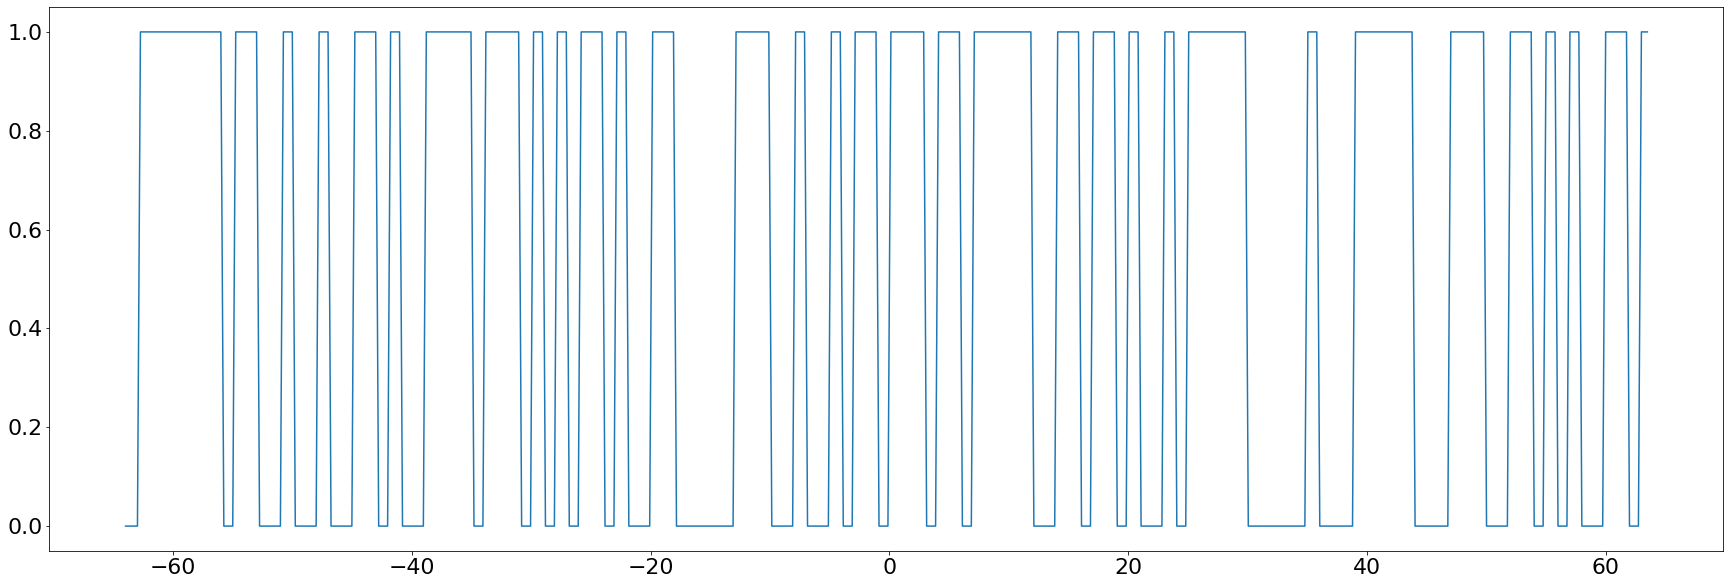

In [ ]:
xspace=np.linspace(-M*delta/2,(M-1)*delta/2,512)
plt.plot(xspace,vt(xspace))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

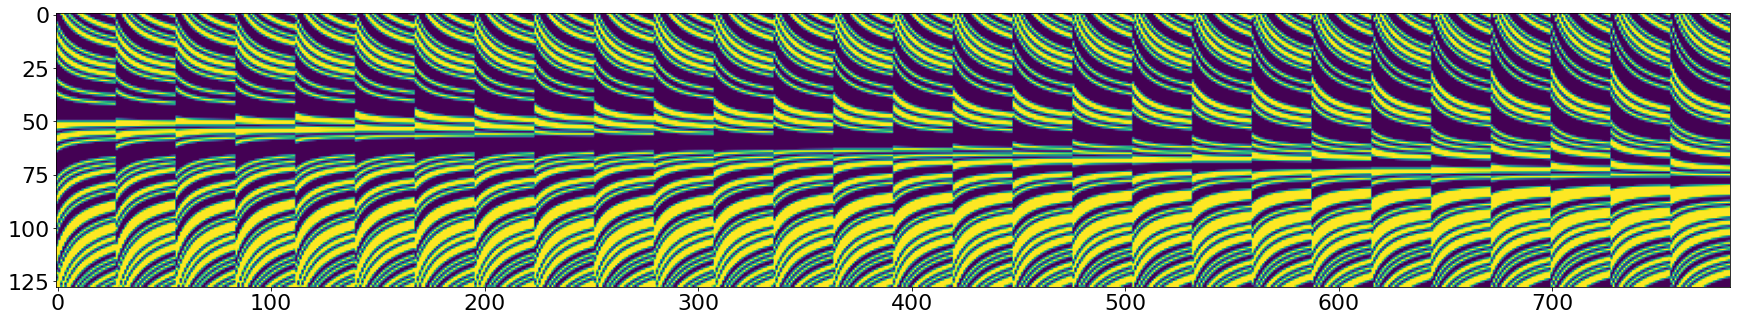

In [6]:
plt.imshow(H)
plt.savefig('codedApertureTomographyH.pdf')
files.download('codedApertureTomographyH.pdf')

We can visualize the projection that each row of H makes on the N by N object space

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

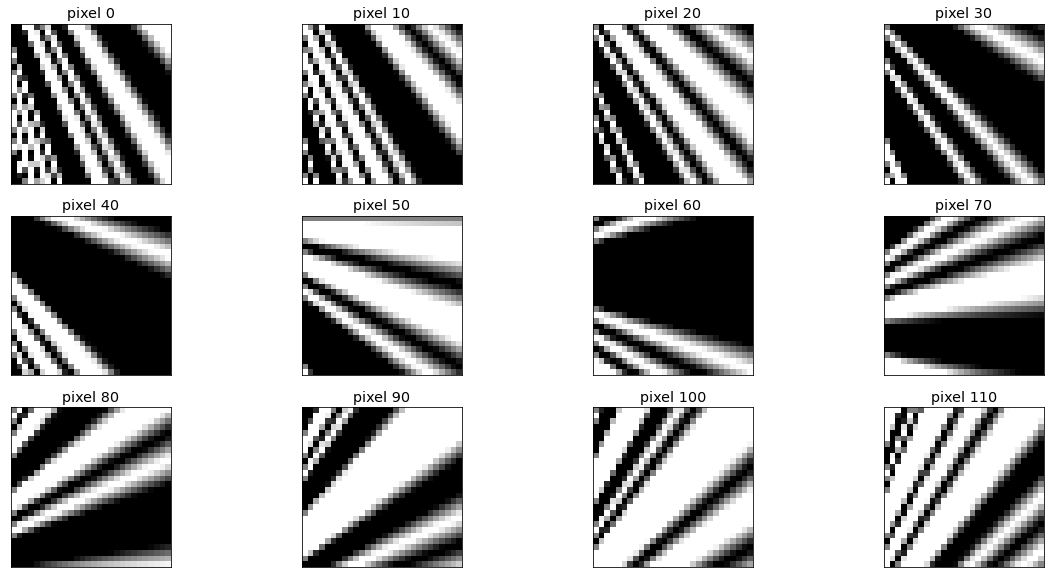

In [10]:
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 12})
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(np.reshape(H[10*i,:],(N,N)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('pixel '+np.str(10*i))
plt.savefig('codedApertureTomographyMeasurements.pdf')
files.download('codedApertureTomographyMeasurements.pdf')


In [12]:
u, lam, vh = np.linalg.svd(H)
ph=np.linalg.pinv(H)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

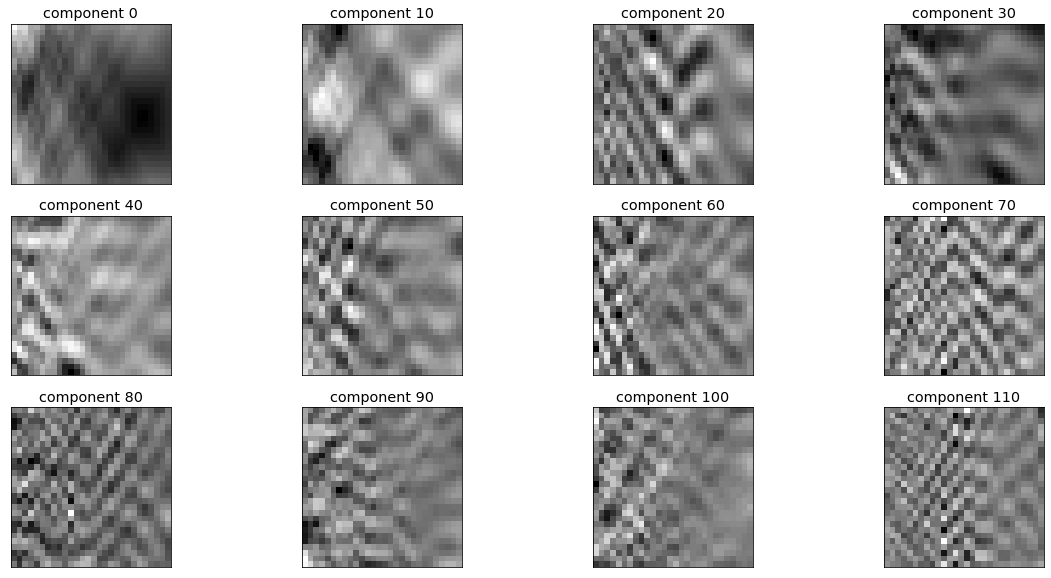

In [13]:

plt.figure(figsize=(20, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(np.reshape(vh[10*i,:],(N,N)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('component '+np.str(10*i))
plt.savefig('codedApertureTomographySV.pdf')
files.download('codedApertureTomographySV.pdf')


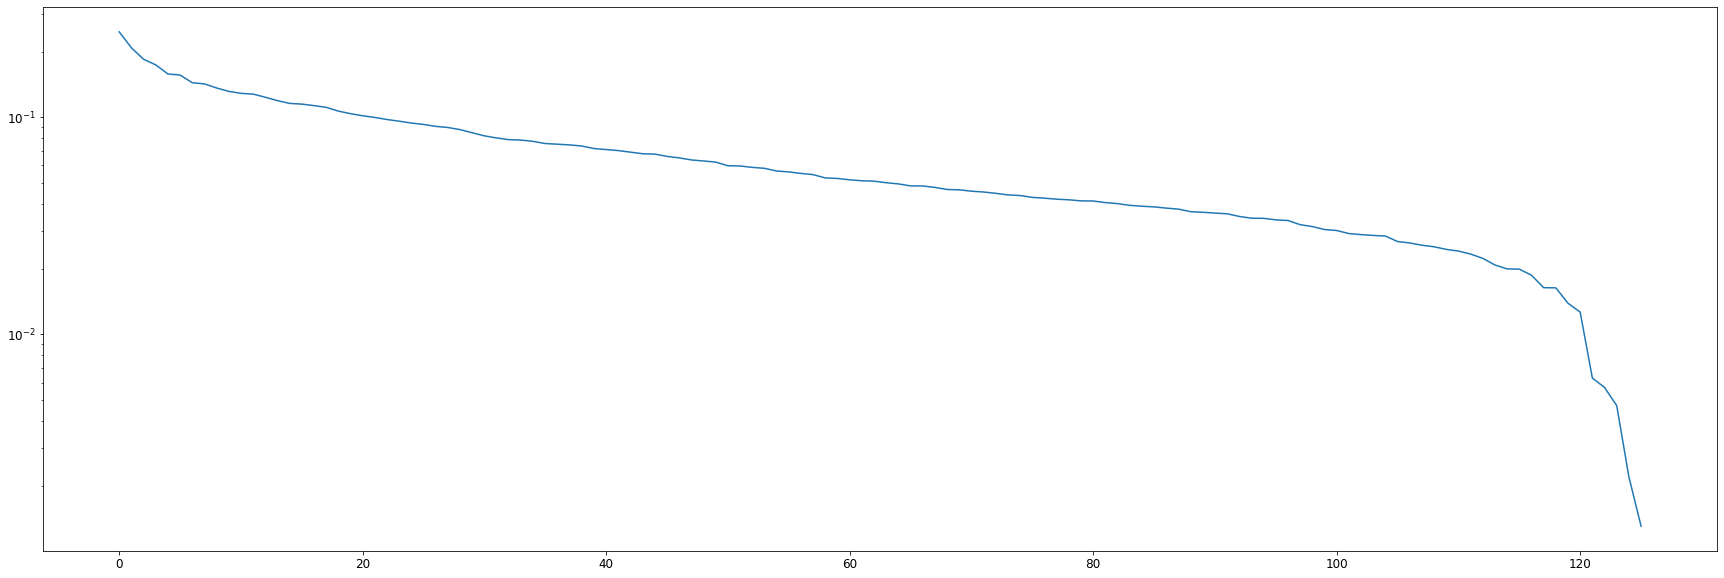

In [16]:
plt.semilogy(lam[1:127]/lam[0])


# Neural Compressive Tomography

## Image database

In [17]:
# load the mnist dataset of characters


(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

11501568/11490434 [==============================] - 0s 0us/step


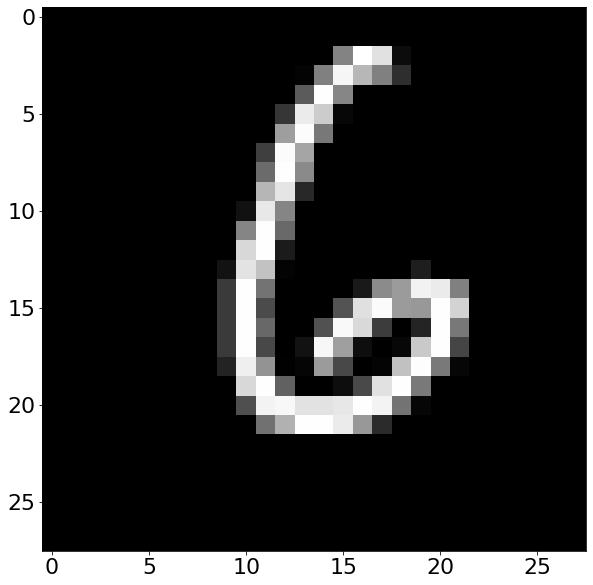

In [ ]:
plt.imshow(x_train[32],cmap='gray')

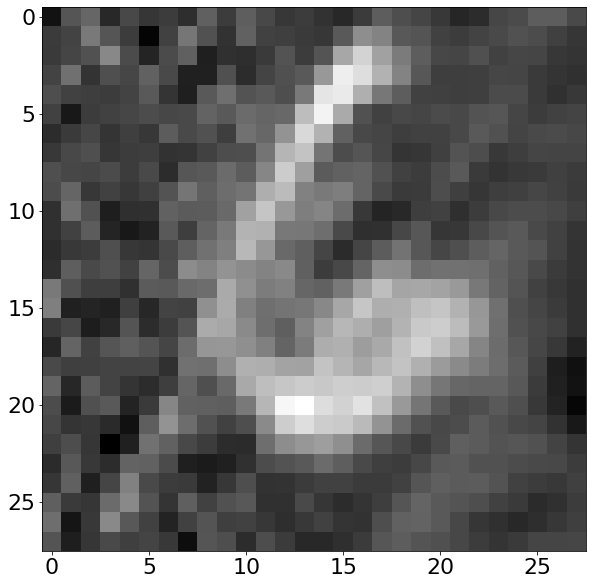

In [ ]:
plt.imshow(np.reshape(np.matmul(np.linalg.pinv(H),np.matmul(H,np.reshape(x_train[32],N**2))),(N,N)))

###  prepare training data

In [20]:



g_test=np.zeros(np.shape(x_test))
g_train=np.zeros(np.shape(x_train))
for pop in range(np.shape(x_test)[0]):
  g_test[pop,:,:]= np.reshape(np.matmul(ph,np.matmul(H,np.reshape(x_test[pop],N**2))),(N,N))
  g_test[pop,:,:]=g_test[pop,:,:]/np.max(g_test[pop,:,:])
for pop in range(np.shape(x_train)[0]):
  g_train[pop,:,:]=np.reshape(np.matmul(ph,np.matmul(H,np.reshape(x_train[pop],N**2))),(N,N))
  g_train[pop,:,:]=g_train[pop,:,:]/np.max(g_train[pop,:,:])
x_train = np.reshape(x_train, (len(x_train), N, N, 1))
x_test = np.reshape(x_test, (len(x_test), N, N, 1))
g_train = np.reshape(g_train, (len(g_train), N, N, 1))
g_test = np.reshape(g_test, (len(g_test), N, N, 1))

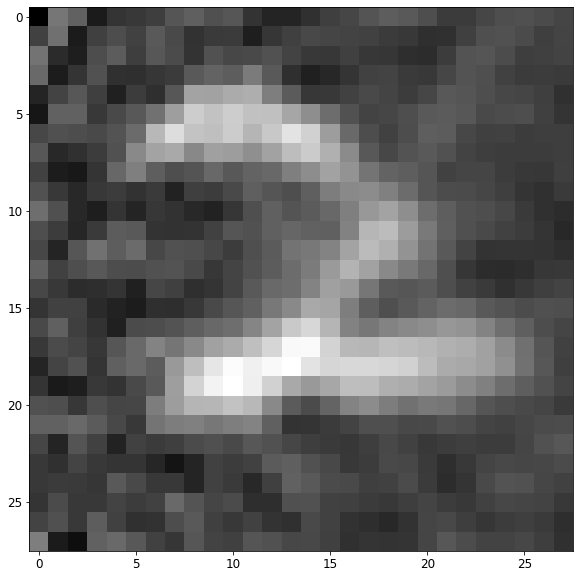

In [21]:
plt.imshow(g_test[1932].reshape(N, N))

### Encoder/denoising model

In [22]:
inputs=keras.Input(shape=(N, N, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)


# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

autoencoder = keras.Model(inputs, x)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        16416     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 16)        4624  

### Training

In [23]:
autoencoder.fit(
    x=g_train,
    y=x_train,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/30
469/469 [==============================] - 21s 10ms/step - loss: 0.0167 - val_loss: 0.0089
Epoch 2/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0077 - val_loss: 0.0067
Epoch 3/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 4/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 5/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 6/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 7/30
469/469 [==============================] - 4s 10ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 8/30
469/469 [==============================] - 4s 10ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 9/30
469/469 [==============================] - 4s 10ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 10/30
469/469 [==============================] - 4s 10ms/step - loss: 0.0047 - val_loss: 

### Examples of subsampled and estimated images

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

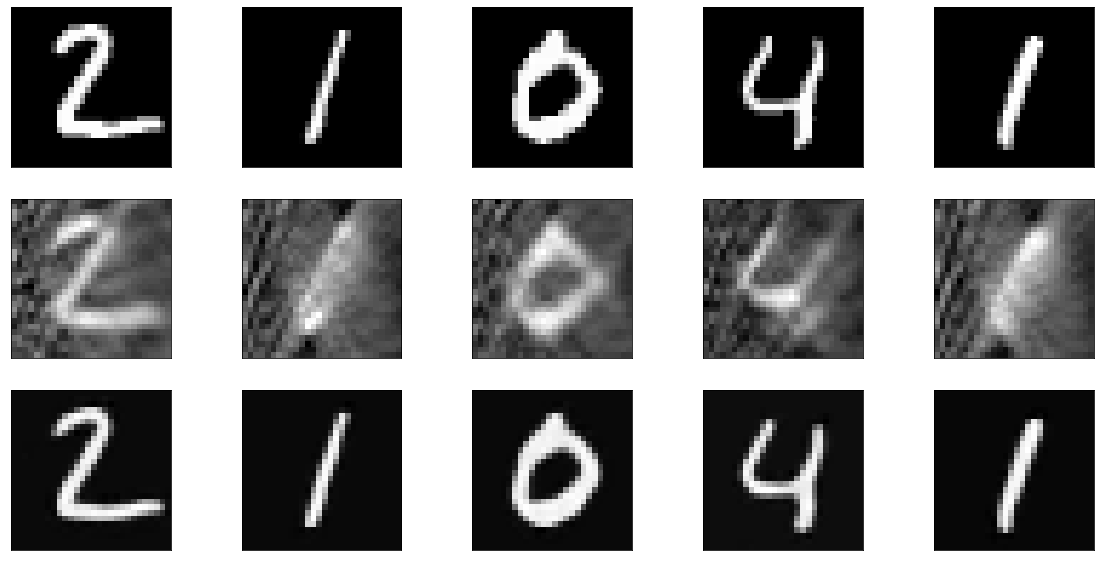

In [24]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    plt.imshow(g_test[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    plt.imshow(autoencoder.predict(g_test[i:(i+1),:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('codedApertureTomography.pdf')
files.download('codedApertureTomography.pdf')